# Some basic analysis on the simulation with a sponge. 

In [1]:
# load appropriate modules
import numpy as np
import xarray as xr
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
%matplotlib inline
from xgcm import Grid
from scipy import linalg as lin
from scipy import signal as sig
from scipy import fftpack as fft
from scipy import interpolate as naiso
from matplotlib import colors, ticker, cm
import xrft
#import gsw
import os
import os.path as op

In [2]:
data_dir = '/swot/SUM04/dbalwada/channel_model/05km_sponge/run/'

In [3]:
model_vars = ['uVeltave','vVeltave','wVeltave', 'Ttave', 
             'UTtave', 'VTtave','WTtave','UUtave', 'UVtave',
              'VVtave', 'TTtave', 'tFluxtave']

ds_sponge_inst = open_mdsdataset(data_dir , delta_t=300,  
                          prefix=model_vars,
                          ignore_unknown_vars=True, geometry='cartesian')

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xmitgcm-0.2.2-py3.6.egg/xmitgcm/utils.py:423: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)


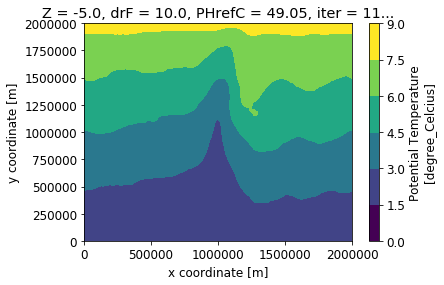

In [26]:
ds_sponge_inst.Ttave.isel(time=-1).sel(Z=0, method='nearest').plot.contourf()

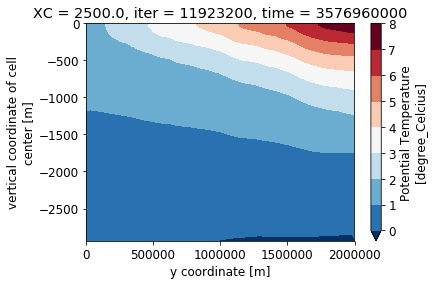

In [28]:
ds_sponge_inst.Ttave.isel(time=-1).sel(XC=0, method='nearest').plot.contourf(
    levels=np.linspace(0,8,9))

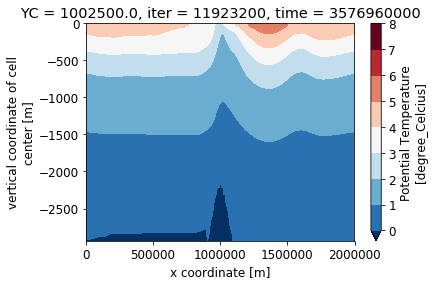

In [45]:
ds_sponge_inst.Ttave.isel(time=-1).sel(YC=1000e3, method='nearest').plot.contourf(
    levels=np.linspace(0,8,9))

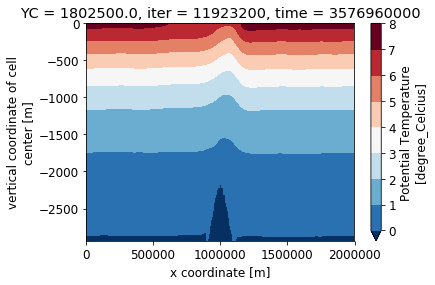

In [46]:
ds_sponge_inst.Ttave.isel(time=-1).sel(YC=1800e3, method='nearest').plot.contourf(
    levels=np.linspace(0,8,9))

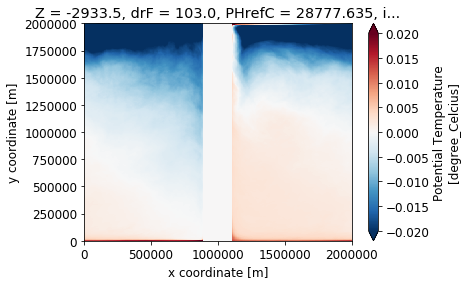

In [56]:
ds_sponge_inst.Ttave.isel(time=-1).sel(Z=-3e3, method='nearest').plot(vmin=-0.02)

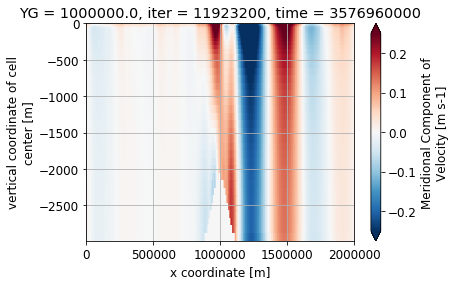

In [65]:
ds_sponge_inst.vVeltave.isel(time=-1).sel(YG=1000e3, method='nearest').plot(vmin=-0.25)
plt.grid()

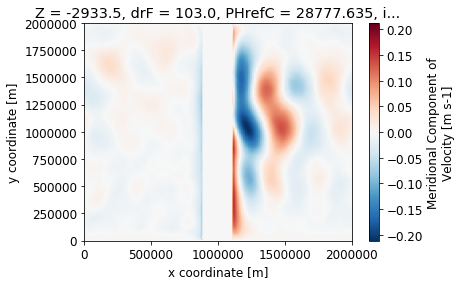

In [51]:
ds_sponge_inst.vVeltave.isel(time=-1).sel(Z=-3e3, method='nearest').plot()

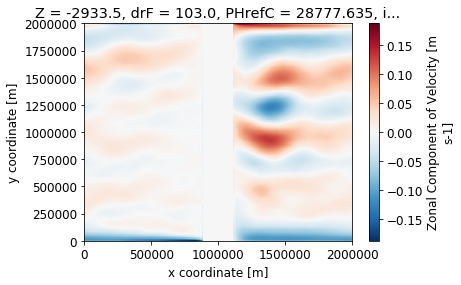

In [52]:
ds_sponge_inst.uVeltave.isel(time=-1).sel(Z=-3e3, method='nearest').plot()

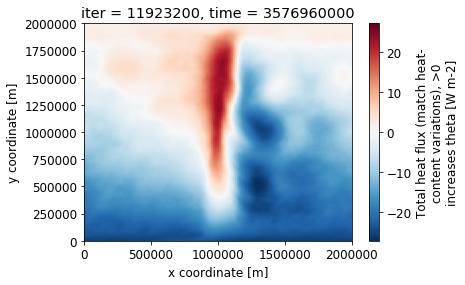

In [25]:
ds_sponge_inst.tFluxtave.isel(time=-1).plot()

In [4]:
ds_layers = open_mdsdataset(data_dir,  delta_t=300, prefix=['DiagLAYERS-transport','DiagLAYERS-diapycnal']
                 ,ignore_unknown_vars=True)


ds_trend = open_mdsdataset(data_dir,  
                         delta_t=300, prefix=['DiagLAYERS-trend']
                 ,ignore_unknown_vars=True)

In [9]:
(ds_layers.time[1]-ds_layers.time[0])/24/3600/360

<xarray.DataArray 'time' ()>
array(5.)

In [5]:
def thickness_budget(ds, ds_trend, layer_name='1TH'):
    """Calculate thickness budget from layers data in xray format."""
    grid = Grid(ds, periodic=['X'])    
    dsnew = {}
    
    diapycnal_map = {
        'surface_forcing': (('LaTs',), 1),
        'mixing_vertical': (('LaTz',), 1),
        'mixing_horizontal': (('LaTh',), 1),
        'advection_tendency': (('LTha', 'LTza'), 1),
        'total_tendency': (('LTto',), (24*60*60.)**-1)
    }
    
    for name, (components, scalefac) in diapycnal_map.items():
        if len(components)>1:
            w = sum(*[ds[cpt + layer_name] for cpt in components])
        else:
            w = ds[components[0] + layer_name]
        w_diff = grid.diff(scalefac * w * ds.rA, layer_name, boundary='fill')
        # we want CONVERGENCE, not divergence, so need a minus sign
        dsnew[name + '_' + layer_name] = -w_diff
        
    # we want CONVERGENCE, not divergence, so need a minus sign
    dsnew['advection_flux' + '_' + layer_name] = (
        - grid.diff(ds['LaVH' + layer_name] * ds.dxG, 'Y', boundary='extend')
        - grid.diff(ds['LaUH' + layer_name] * ds.dyG, 'X') )
    
    dsnew['thickness_trend' + '_' + layer_name] = (
        ds_trend.LaHc1TH.diff(dim='time', label='upper') /
        ds_trend.time.diff(dim='time', label='upper') ) * ds.rA
    
    dsnew['mixing_numerical' + '_' + layer_name] = (
        dsnew['advection_tendency' + '_' + layer_name] -
        dsnew['advection_flux' + '_' + layer_name] )

    return xr.Dataset(dsnew)

In [6]:
def thickness_budget(ds, ds_trend, layer_name='1TH'):
    """Calculate thickness budget from layers data in xray format."""
    grid = Grid(ds, periodic=['X', 'Y'])    
    dsnew = {}
    
    diapycnal_map = {
        'surface_forcing': (('LaTs',), 1),
        'mixing_vertical': (('LaTz',), 1),
        'mixing_horizontal': (('LaTh',), 1),
        'advection_tendency': (('LTha', 'LTza'), 1),
        'total_tendency': (('LTto',), (24*60*60.)**-1)
    }
    
    for name, (components, scalefac) in diapycnal_map.items():
        if len(components)>1:
            w = sum(*[ds[cpt + layer_name] for cpt in components])
        else:
            w = ds[components[0] + layer_name]
        w_diff = grid.diff(scalefac * w * ds.rA, layer_name, boundary='fill')
        # we want CONVERGENCE, not divergence, so need a minus sign
        dsnew[name + '_' + layer_name] = -w_diff
        
    # we want CONVERGENCE, not divergence, so need a minus sign
    dsnew['advection_flux' + '_' + layer_name] = (
        - grid.diff(ds['LaVH' + layer_name] * ds.dxG, 'Y')
        - grid.diff(ds['LaUH' + layer_name] * ds.dyG, 'X') )
    
    dsnew['thickness_trend' + '_' + layer_name] = (
        ds_trend.LaHc1TH.diff(dim='time', label='upper') /
        ds_trend.time.diff(dim='time', label='upper') ) * ds.rA
    
    dsnew['mixing_numerical' + '_' + layer_name] = (
        dsnew['advection_tendency' + '_' + layer_name] -
        dsnew['advection_flux' + '_' + layer_name] )

    return xr.Dataset(dsnew)

In [8]:
ds_tb = thickness_budget(ds_layers, ds_trend)


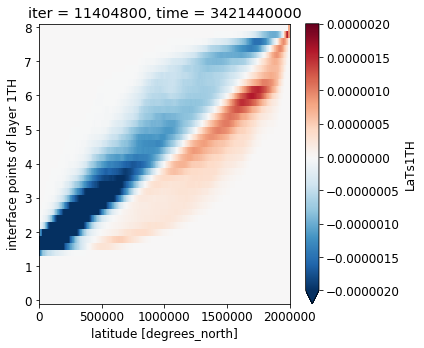

In [11]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(6,5))

ds_layers.LaTs1TH[0].mean(dim='XC').plot(vmin=-2e-6)

plt.tight_layout()


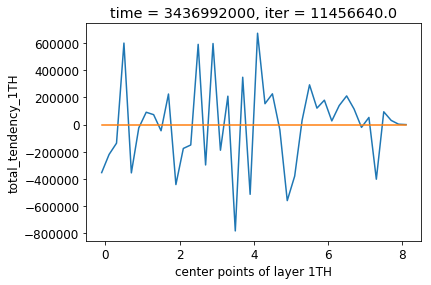

In [12]:
ds_tb.thickness_trend_1TH[10].sum(dim=['YC','XC']).plot()
ds_tb.total_tendency_1TH[10].sum(dim=['YC','XC']).plot()

In [14]:
grid = Grid(ds_layers, periodic='X')

In [41]:
ds_layers

<xarray.Dataset>
Dimensions:              (XC: 400, XG: 400, YC: 400, YG: 400, Z: 40, Zl: 40, Zp1: 41, Zu: 40, layer_1TH_bounds: 43, layer_1TH_center: 42, layer_1TH_interface: 41, time: 2)
Coordinates:
  * time                 (time) int64 3421440000 3576960000
  * XC                   (XC) >f4 2500.0 7500.0 12500.0 ... 1992500.0 1997500.0
  * YC                   (YC) >f4 2500.0 7500.0 12500.0 ... 1992500.0 1997500.0
  * XG                   (XG) >f4 0.0 5000.0 10000.0 ... 1990000.0 1995000.0
  * YG                   (YG) >f4 0.0 5000.0 10000.0 ... 1990000.0 1995000.0
  * Z                    (Z) >f4 -5.0 -15.0 -25.0 ... -2727.5 -2830.5 -2933.5
  * Zp1                  (Zp1) >f4 0.0 -10.0 -20.0 ... -2779.0 -2882.0 -2985.0
  * Zu                   (Zu) >f4 -10.0 -20.0 -30.0 ... -2779.0 -2882.0 -2985.0
  * Zl                   (Zl) >f4 0.0 -10.0 -20.0 ... -2676.0 -2779.0 -2882.0
    rA                   (YC, XC) >f4 dask.array<shape=(400, 400), chunksize=(400, 400)>
    dxG             

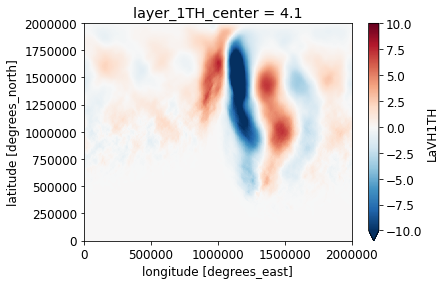

In [40]:
ds_layers.LaVH1TH.mean('time').sel(layer_1TH_center=4, method='nearest').plot(vmin=-10)

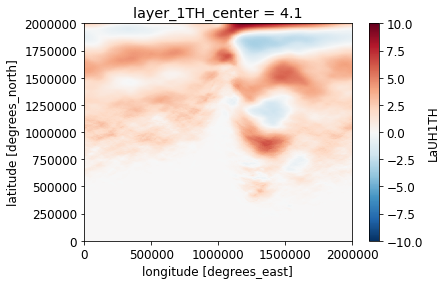

In [44]:
ds_layers.LaUH1TH.mean('time').sel(layer_1TH_center=4, method='nearest').plot(vmin=-10)

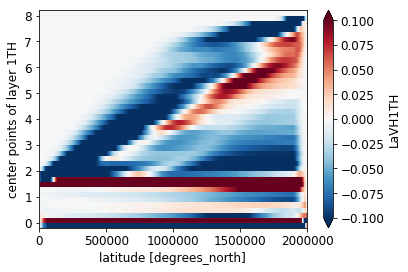

In [39]:
ds_layers.LaVH1TH.mean('time').mean('XC').plot(vmin=-0.1)

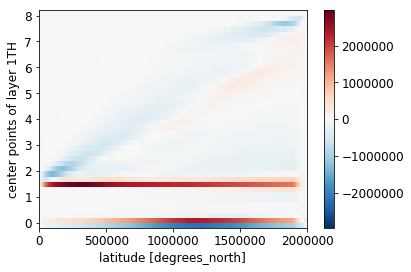

In [34]:
(ds_layers.LaVH1TH.mean(dim=('time'))*ds_layers.dxG.sum(dim='XC')).mean('XC').plot()

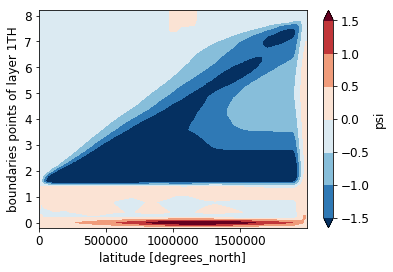

In [43]:
psi = -grid.cumsum((ds_layers.LaVH1TH.mean(dim=('time'))*ds_layers.dxG).sum(dim='XC'), '1TH', boundary='fill').rename('psi')
(psi / 1e6).plot.contourf(vmin=-1.5)

In [33]:
psi

<xarray.DataArray 'psi' (layer_1TH_bounds: 43, YG: 400)>
dask.array<shape=(43, 400), dtype=float32, chunksize=(1, 400)>
Coordinates:
  * layer_1TH_bounds  (layer_1TH_bounds) >f4 -0.2 0.0 0.2 0.4 ... 7.8 8.0 8.2
  * YG                (YG) >f4 0.0 5000.0 10000.0 ... 1990000.0 1995000.0

Text(0.5, 1.0, 'Tranformation : 20km')

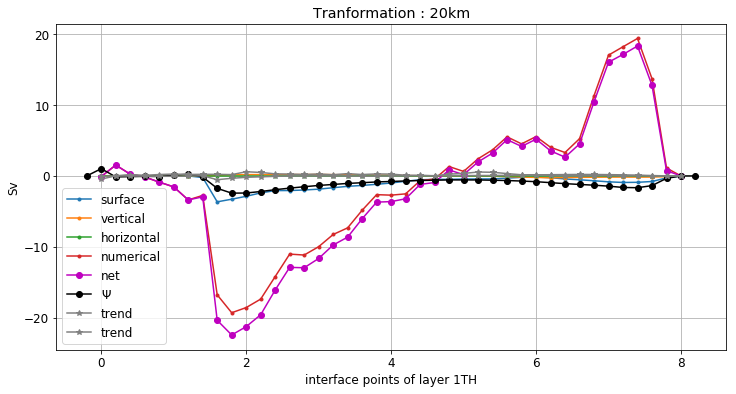

In [18]:
run_name = '05km sponge'
ds = ds_layers

# calculate numerical mixing
ds['w_numerical'] = grid.cumsum(ds_tb.mixing_numerical_1TH, '1TH', to='inner') / ds.rA
ds['w_true_trend'] = grid.cumsum(ds_tb.thickness_trend_1TH, '1TH', to='inner') / ds.rA


def plot_transformation(array, ax, jmax=25, **kwargs):
    omega = (array * ds.rA).mean(dim='time').isel(YC=slice(0,-jmax)).sum(dim=('XC','YC'))/1e6
    omega.plot(ax=ax, **kwargs)

fig, ax = plt.subplots(figsize=(12,6))

plot_transformation(ds.LaTs1TH, ax, marker='.', label='surface')
plot_transformation(ds.LaTz1TH, ax, marker='.', label='vertical')
plot_transformation(ds.LaTh1TH, ax, marker='.', label='horizontal')
plot_transformation(ds.w_numerical, ax, marker='.', label='numerical')

net = (ds.LaTs1TH + ds.LaTz1TH + ds.LaTh1TH + ds.w_numerical)
plot_transformation(net, ax, marker='o', color='m', label='net')

p = psi[:,-25]/1e6
p.plot(ax=ax, marker='o', color='k', label=r'$\Psi$')

plot_transformation(ds.LTto1TH/(24*60*60), ax, marker='*', color='0.5', label='trend')
plot_transformation(ds.w_true_trend, ax, marker='*', color='0.5', label='trend')

#plt.ylim([-0.8, 0.8])
plt.grid()
plt.ylabel('Sv')
plt.legend()
plt.title('Tranformation : ' + run_name)
#plt.savefig('figures/channel_%s_transformation.pdf' % run_name)